## Mutivariate Regression Analysis

### Assumptions of the Model
It's essential to understand the assumptions of the model before we start building and coding. Each assumption if violated means we may have to take extra steps to improve our model or in some cases dump the model altogether. Here is a list of the assumptions of the model:

1.Regression residuals must be normally distributed.

2.A linear relationship is assumed between the dependent variable and the independent variables.

3.The residuals are homoscedastic and approximately rectangular-shaped.

4.Absence of multicollinearity is expected in the model, meaning that independent variables are not too highly correlated.

5.No Autocorrelation of the residuals.

I will be explaining these assumptions in more detail as we arrive at each of them in the tutorial. At this point, however, we need to have an idea of what they are

### Section One: Import our Libraries
The first thing we need to do is import the libraries we will be using in this tutorial. To visualize our data, we will be using matplotlib and seaborn to create heatmaps and a scatter matrix. To build our model, we will be using the sklearn library, and the evaluation will be taking place with the statsmodels library. I've also added a few additional modules to help calculate certain metrics.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

### Section Two: Load the Data into Pandas
After we've loaded our libraries, we can begin the process of importing and exploring our data. I've created an excel file with all the data we will be using in this tutorial. It contains 10 explanatory variables and 1 dependent variable. After we've loaded the data into the data frame, we will need to replace all the .. values with nan as these represent missing values in our dataset.

This dataset was downloaded from the World Bank website; if you would like to visit the site yourself, I encourage you to visit the link provided below. There is a tremendous amount of data available for free, that can be used across a wide range of models.

Link: https://data.worldbank.org/

From here, we will set the index of our data frame using the set_index() function to the Year column. The reasoning behind this is because it will make selecting the data easier. After we've defined the index, we convert the entire data frame to a float data type and then select years 1969 to 2016. These years were selected because they do not contain any missing values.

To make selecting the columns a little easier, we will rename all of our columns. I'll create a dictionary where the keys represent the old column names and the values associated with those keys are the new column names. I'll then call the rename() method and pass through the new columns dictionary.

Finally, I'll check one last time for any missing values using isnull().any(), which will return true for a given column if any values are missing, and then print the head of the data frame.

In [2]:
# load the data and replace the '..' with nan
econ_df = pd.read_excel('C:/Users/HP/Desktop/Data Science/Data/korea_data.xlsx')
econ_df = econ_df.replace('..','nan')

# set the index to the year column
econ_df = econ_df.set_index('Year')

# set the data type and select rows up to 2016
econ_df = econ_df.astype(float)
econ_df = econ_df.loc['1969':'2016']

column_names = {'Unemployment, total (% of total labor force) (national estimate)':'unemployment',
                'GDP growth (annual %)': 'gdp_growth',
                'Gross capital formation (% of GDP)':'gross_capital_formation',
                'Population growth (annual %)':'pop_growth', 
                'Birth rate, crude (per 1,000 people)':'birth_rate',
                'Broad money growth (annual %)':'broad_money_growth',                
                'Final consumption expenditure (% of GDP)':'final_consum_gdp',
                'Final consumption expenditure (annual % growth)':'final_consum_growth',
                'General government final consumption expenditure (annual % growth)':'gov_final_consum_growth',
                'Gross capital formation (annual % growth)':'gross_cap_form_growth',
                'Households and NPISHs Final consumption expenditure (annual % growth)':'hh_consum_growth'}

# rename columns
econ_df = econ_df.rename(columns = column_names)

# check for nulls
display('-'*100)
display(econ_df.isnull().any())

# display the first five rows
display('-'*100)
display(econ_df.head())

'----------------------------------------------------------------------------------------------------'

gdp_growth                 False
gross_capital_formation    False
pop_growth                 False
birth_rate                 False
broad_money_growth         False
final_consum_growth        False
gov_final_consum_growth    False
gross_cap_form_growth      False
hh_consum_growth           False
unemployment               False
dtype: bool

'----------------------------------------------------------------------------------------------------'

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
Year,,,,,,,,,,
1969,14.541235,29.943577,2.263434,30.663,60.984733,10.693249,10.640799,29.908118,10.700325,4.86
1970,9.997407,26.338200,2.184174,31.200,27.422864,10.161539,7.279573,0.058667,10.557300,4.51
1971,10.454693,25.558501,1.971324,31.200,20.844481,9.330434,8.610547,15.172870,9.426969,4.57
1972,7.150715,21.404761,1.875999,28.400,33.815028,5.788458,8.134824,-13.056701,5.471355,4.59
1973,14.827554,25.872858,1.768293,28.300,36.415629,8.089952,2.287729,32.098276,8.927295,4.04


### Section Three: Check for Perfect Multicollinearity
One of the first things we can do after loading our data is to validate one of the assumptions of our model; in this case, we will be checking for multicollinearity.

### What is multicollinearity?
One of the assumptions of our model is that there isn't any Perfect multicollinearity. Multicollinearity is where one of the explanatory variables is highly correlated with another explanatory variable. In essence, one of the X variables is almost perfectly correlated with another or multiple X variables.

### What is the problem with multicollinearity?

The problem with multicollinearity, from a math perspective, is that the coefficient estimates themselves tend to be unreliable. Additionally, the standard errors of slope coefficients become artificially inflated. Because the standard error is used to help calculate the p-value, this leads to a higher probability that we will incorrectly conclude that a variable is not statistically significant.

Another way we can look at this problem is by using an analogy. Imagine we ask you to go to a concert and determine who was the best singer. This task would become very challenging if you couldn't distinguish the two singers because they are singing at the same volume. The idea is the same in our analysis, how can we determine which variable is playing a role in our model if we can't distinguish the two? The problem is we can't.

Now a little correlation is fine, but if it gets too high, we can effectively distinguish the two variables. The other issue that arises is that when we have highly correlated exploratory variables is that, in a sense, we have duplicates. This means that we can remove one of them and we haven't lost anything; the model would still perform the same.

### How to test for multicollinearity?
Because of these drawbacks, we should always check for multicollinearity in our data. Now, in the step above I purposely pull in variables that I knew would be highly correlated with each other; that way we could see some examples of variables that would cause some issues.

The first thing we can do is create a correlation matrix using the corr() function; this will create a matrix with each variable having its correlation calculated for all the other variables. Keep in mind, if you travel diagonally down the matrix all the associations should be one, as it is calculating the correlation of the variable with itself. When we have multiple variables as we do, I sometimes prefer to use a correlation heatmap this way I can quickly identify the highly correlated variables, by just looking for the darker colors.

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
gdp_growth,1.000000,0.086712,0.567216,0.553225,0.335249,0.855835,0.098183,0.825496,0.868848,-0.160783
gross_capital_formation,0.086712,1.000000,-0.215243,-0.241668,-0.163803,0.266617,0.118075,0.187885,0.268592,-0.618524
pop_growth,0.567216,-0.215243,1.000000,0.978754,0.548336,0.470449,0.357042,0.317556,0.442187,0.279486
birth_rate,0.553225,-0.241668,0.978754,1.000000,0.530563,0.458319,0.370517,0.305254,0.428266,0.313783
broad_money_growth,0.335249,-0.163803,0.548336,0.530563,1.000000,0.290507,0.287270,0.235561,0.267220,0.336335
final_consum_growth,0.855835,0.266617,0.470449,0.458319,0.290507,1.000000,0.323250,0.700392,0.993526,-0.299310
gov_final_consum_growth,0.098183,0.118075,0.357042,0.370517,0.287270,0.323250,1.000000,0.033376,0.216641,0.007940
gross_cap_form_growth,0.825496,0.187885,0.317556,0.305254,0.235561,0.700392,0.033376,1.000000,0.715021,-0.207261
hh_consum_growth,0.868848,0.268592,0.442187,0.428266,0.267220,0.993526,0.216641,0.715021,1.000000,-0.304797
unemployment,-0.160783,-0.618524,0.279486,0.313783,0.336335,-0.299310,0.007940,-0.207261,-0.304797,1.000000


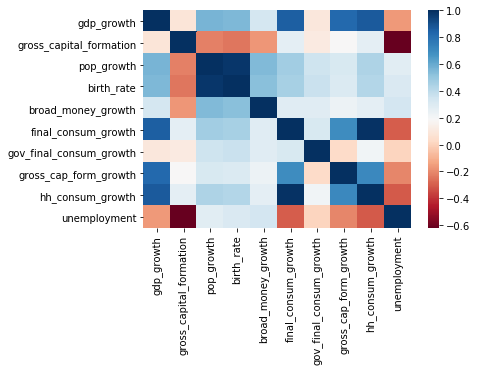

In [3]:
# calculate the correlation matrix
corr = econ_df.corr()

# display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

Looking at the heatmap along with the correlation matrix we can identify a few highly correlated variables. For example, if you look at the correlation between birth_rate and pop_growth it ends up at almost .98. This is an extremely high correlation and marks it as a candidate to be removed. Logically it makes sense that these two are highly correlated; if you're having more babies, then the population should be increasing.

### However, we should be more systematic in our approach to removing highly correlated variables. One method we can use is the variance_inflation_factor which is a measure of how much a particular variable is contributing to the standard error in the regression model. When significant multicollinearity exists, the variance inflation factor will be huge for the variables in the calculation.

A general recommendation is that if any of our variables come back with a value of 5 or higher, then they should be removed from the model. I decided to show you how the VFI comes out before we drop the highly correlated variables and after we remove the highly correlated variables. Going forward in the tutorial we will only be using the econ_df_after data frame.

In [4]:
# define two data frames one before the drop and one after the drop
econ_df_before = econ_df
econ_df_after = econ_df.drop(['gdp_growth','birth_rate', 'final_consum_growth','gross_capital_formation'], axis = 1)

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
# ADDING CONSTANT FOR 2 DATASETS X1 AND X1
X1 = sm.tools.add_constant(econ_df_before)
X2 = sm.tools.add_constant(econ_df_after)

# create the series for both- FINFING VIF FOR ALL COLUMNS IN X1 AND X2
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index=X2.columns)

# display the series- COMPARING THE SCORES
print('DATA BEFORE')
print('-'*100)
display(series_before)

print('DATA AFTER')
print('-'*100)
display(series_after)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                       314.550195
gdp_growth                    9.807879
gross_capital_formation       2.430057
pop_growth                   25.759263
birth_rate                   26.174368
broad_money_growth            1.633079
final_consum_growth        2305.724583
gov_final_consum_growth      32.527332
gross_cap_form_growth         3.796420
hh_consum_growth           2129.093634
unemployment                  2.800008
dtype: float64

DATA AFTER
----------------------------------------------------------------------------------------------------


const                      27.891150
pop_growth                  1.971299
broad_money_growth          1.604644
gov_final_consum_growth     1.232229
gross_cap_form_growth       2.142992
hh_consum_growth            2.782698
unemployment                1.588410
dtype: float64

Looking at the data above we now get some confirmation about our suspicion. It makes sense to remove either birth_rate or pop_growth and some of the consumption growth metrics. Once we remove those metrics and recalculate the VFI, we get a passing grade and can move forward.

I also want to demonstrate another way to visualize our data to check for multicollinearity. Inside of pandas, there is a scatter_matrix chart that will create a scatter plot for each variable in our dataset against another variable. This is a great tool for visualizing the correlation of one variable across all the other variables in the dataset. I'll take my econ_df_after and pass it through the scatter_matrix method. What you're looking for is a more random distribution, there shouldn't be any strong trends in the scatter matrix as this would be identifying correlated variables. Now, for our explanatory variable, we want to see trends!

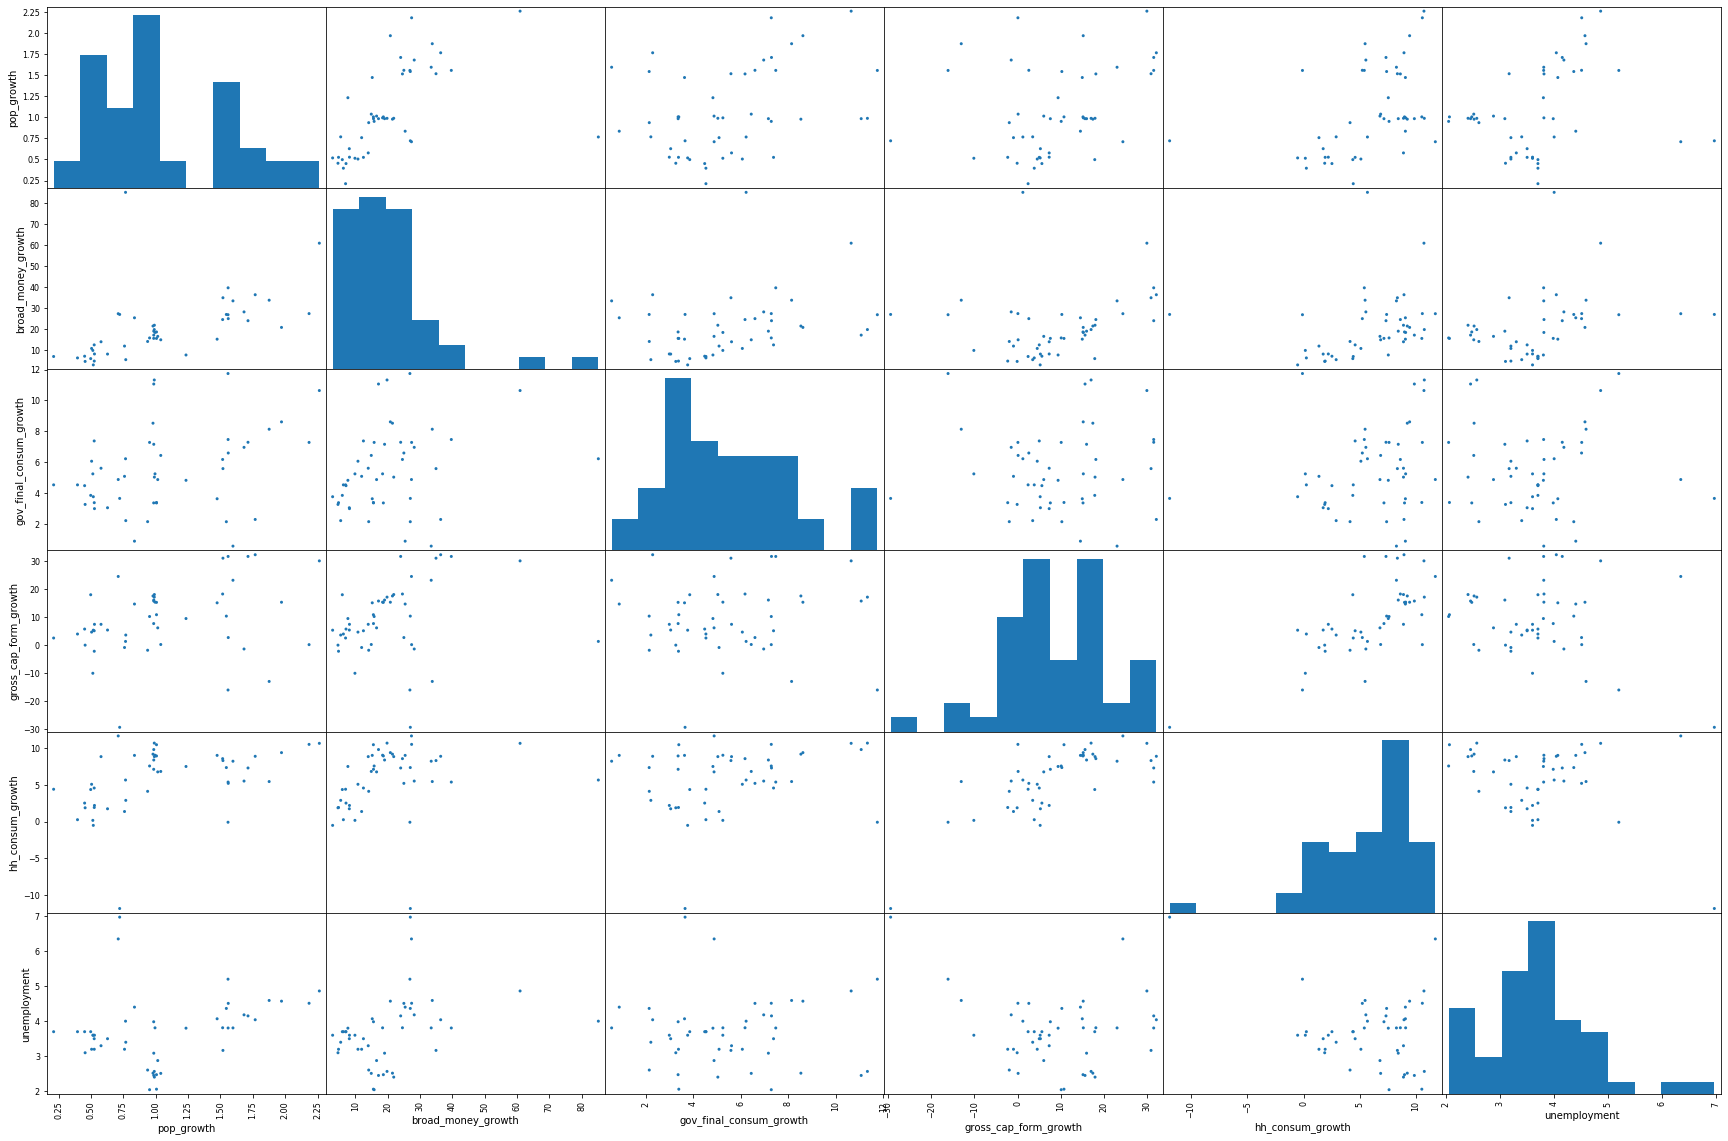

In [5]:
# define the plot
pd.plotting.scatter_matrix(econ_df_after, alpha = 1, figsize = (30, 20))

# show the plot
plt.show()

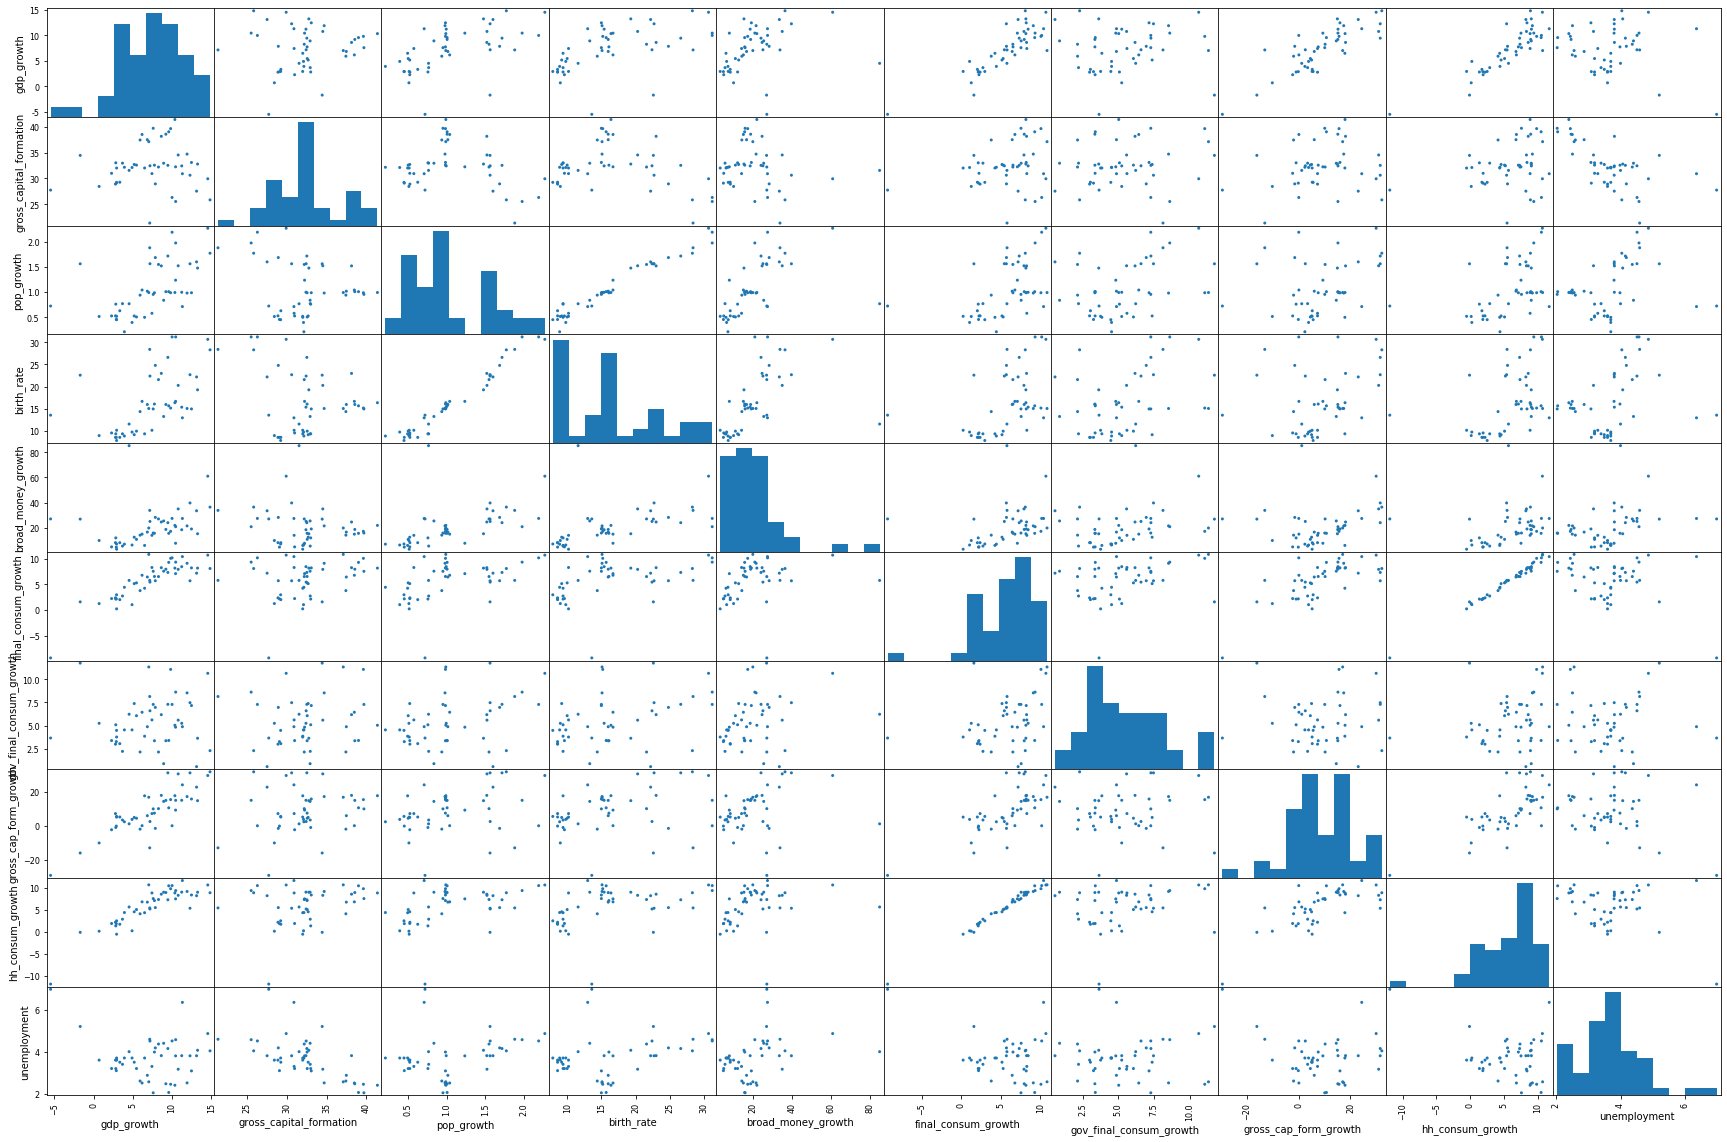

In [6]:
# define the plot
pd.plotting.scatter_matrix(econ_df_before, alpha = 1, figsize = (30, 20))

# show the plot
plt.show()

### Section Four: Describe the Data Set
Before we get to an in-depth exploration of the data or even building the model, we should explore the data a little more and see how the data is distributed and if there are any outliers. I will be adding a few more metrics to the summary data frame, sp that it now includes a metric for three standard deviations below and above the mean.

I'll store my information in a new variable called desc_df.

In [7]:
# get the summary
desc_df = econ_df.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.280315,32.433236,1.058072,16.340896,20.426621,5.820239,5.419214,8.965681,5.879176,3.678096
std,4.209306,4.136932,0.514039,6.814683,14.748442,3.627444,2.622254,12.629912,4.227720,0.968616
min,-5.471219,21.404761,0.211998,7.900000,2.980690,-9.288825,0.560957,-29.403255,-11.894309,2.048000
25%,4.374899,29.776910,0.615602,9.950000,10.586461,3.591334,3.384407,2.114078,3.825773,3.150475
50%,7.513471,32.335229,0.985132,15.150000,17.807598,6.531163,5.056509,7.431966,6.999971,3.700000
75%,10.376191,34.474874,1.525765,21.750000,26.923837,8.179037,7.188470,16.210283,8.938837,4.088500
max,14.827554,41.374062,2.263434,31.200000,85.203081,10.834413,11.742807,32.098276,11.711835,6.963000
+3_std,19.908232,44.844034,2.600188,36.784945,64.671947,16.702571,13.285976,46.855416,18.562336,6.583944
-3_std,-5.347602,20.022439,-0.484044,-4.103153,-23.818705,-5.062092,-2.447547,-28.924054,-6.803985,0.772247


One thing that I want to mention is that we have only 50 observations, but 6 (minus the 3 we dropped) exploratory variables. Many people would argue that we need more data to have this many exploratory variables and to be honest, they are correct. Generally we should aim for at least 20 instances for each variable; however, some argue only 10 would do. Regardless, we will see at the end of our model that we only end up with 4 exploratory variables so that we will satisfy that rule.

Looking at the data frame up above, a few values are standing out, for example, the maximum value in the broad_money_growth column is almost four standard deviations above the mean. Such an enormous value would qualify as an outlier.

### Filtering the Dataset
To drop or not to drop, that is the question. Generally, if we believe the data has been entered in error, we should remove it. However, in this situation, the values that are being identified as outliers are correct values and are not errors. Both of these values were produced during specific moments in time. The one in 1998 was right after the Asian Financial Crisis, and the one in 2001 is right after the DotCom Bubble, so it's entirely conceivable that these values were produced in extreme albeit rare conditions. For this reason, I will NOT be removing these values from the dataset as they recognize actual values that took place.

Imagine if we wanted to remove the values that have an amount exceeding three standard deviations. How would we approach this? Well, if we leverage the numpy module and the scipy module we can filter out the rows using the stats.zscore function. The Z-score is the number of standard deviations from the mean a data point is, so if it's less than 3 we keep it otherwise we drop it. From here, I also provided a way to let us know what rows were removed by using the index.difference the function which will show the difference between the two datasets.

In [8]:
# filter the data frame to remove the values exceeding 3 standard deviations
econ_remove_df = econ_df[(np.abs(stats.zscore(econ_df)) < 3).all(axis=1)]

# what rows were removed
econ_df.index.difference(econ_remove_df.index)

Int64Index([1998, 2001], dtype='int64', name='Year')

In [12]:
# New Dataset
econ_remove_df

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
Year,,,,,,,,,,
1969,14.541235,29.943577,2.263434,30.663,60.984733,10.693249,10.640799,29.908118,10.700325,4.8600
1970,9.997407,26.338200,2.184174,31.200,27.422864,10.161539,7.279573,0.058667,10.557300,4.5100
1971,10.454693,25.558501,1.971324,31.200,20.844481,9.330434,8.610547,15.172870,9.426969,4.5700
1972,7.150715,21.404761,1.875999,28.400,33.815028,5.788458,8.134824,-13.056701,5.471355,4.5900
1973,14.827554,25.872858,1.768293,28.300,36.415629,8.089952,2.287729,32.098276,8.927295,4.0400
1974,9.460873,32.533408,1.712705,26.600,24.036652,7.323853,7.288576,31.493083,7.328337,4.1500
1975,7.863512,28.959267,1.682000,24.800,28.231630,5.714445,6.960465,-1.493720,5.539527,4.1800
1976,13.115159,27.555990,1.596559,22.200,33.484656,7.182714,0.560957,23.006080,8.254930,3.8076
1977,12.277661,30.630713,1.559039,22.700,39.705763,5.701161,7.468013,31.486450,5.401645,3.8057


### Section Five: Build the Model
Okay, now that we've loaded, cleaned, and explored the data we can proceed to the next part, building the model. The first thing we need to do is, define our exploratory variables and our explanatory variable. From here, let's split the data into a training and testing set; a healthy ratio is 20% testing and 80% training but a 30% 70% split is also ok.

After splitting the data, we will create an instance of the linear regression model and pass through the X_train and y_train variables using the fit() function.

In [13]:
# define our input variable (X) & output variable
econ_df_after = econ_df.drop(['birth_rate', 'final_consum_growth','gross_capital_formation'], axis = 1)

X = econ_df_after.drop('gdp_growth', axis = 1)
Y = econ_df_after[['gdp_growth']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Exploring the Output
With the data now fitted to the model, we can explore the output. The first thing we should do is look at the intercept of the model, and then we will print out each of the coefficients of the model. I print everything out using a loop to make it more efficient.

In [14]:
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 2.08
----------------------------------------------------------------------------------------------------
The Coefficient for pop_growth is 2.0
The Coefficient for broad_money_growth is -0.0017
The Coefficient for gov_final_consum_growth is -0.21
The Coefficient for gross_cap_form_growth is 0.14
The Coefficient for hh_consum_growth is 0.51
The Coefficient for unemployment is 0.027


The intercept term is the value of the dependent variable when all the independent variables are equal to zero. For each slope coefficient, it is the estimated change in the dependent variable for a one unit change in that particular independent variable, holding the other independent variables constant.

For example, if all the independent variables were equal to zero, then the gdp_growth would be 2.08%. If we looked at the gross_cap_form_growth while holding all the other independent variables constant, then we would say for a 1 unit increase in gross_cap_form_growth would lead to a 0.14% increase in GDP growth.

We can also now make predictions with our newly trained model. The process is simple; we call the predict method and then pass through some values. In this case, we have some values predefined with the x_test variable so we will pass that through. Once we do that, we can select the predictions by slicing the array.

In [15]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[ 7.61317534],
       [ 6.31344066],
       [ 5.06818662],
       [ 4.19869856],
       [11.11885324]])

### Section Six: Evaluating the Model
Using the Statsmodel
To make diagnosing the model easier, we will, from this point forward, be using the statsmodel module. This module has built-in functions that will make calculating metrics quick. However, we will need "rebuild" our model using the statsmodel module. We do this by creating a constant variable, call the OLS() method and then the fit() method. We now have a new model, and the first thing we need to do is to make sure that the assumptions of our model hold. This means checking the following:


Regression residuals must be normally distributed.
The residuals are homoscedastic

Absence of multicollinearity (we did this above).
No Autocorrelation.

In [17]:
# Inoder to run the ols method we need to check the wether assumptions are sattisfied
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

### Checking for Heteroscedasticity

### What is Heteroscedasticity?
One of the assumptions of our model is that there is no heteroscedasticity. What exactly does this mean? Well, to give a simple definition it merely means the standard errors of a variable, monitored over a specific amount of time, are non-constant. Let's imagine a situation where heteroscedasticity could exist.

Imagine we modeled household consumption based on income, something we would probably notice is how the variability of expenditures changes depending on how much income you have. In simple terms, we would see that households with more income spend money on a broader set of items compared to lower income households that would only be able to focus on the main staples. This results in standard errors that change over income levels.

### What is the problem with heteroscedasticity?
There are two big reasons why you want homoscedasticity:

1.While heteroscedasticity does not cause bias in the coefficient estimates, it causes the coefficient estimates to be less precise. The Lower precision increases the likelihood that the coefficient estimates are further from the correct population value.

2.Heteroscedasticity tends to produce p-values that are smaller than they should be. This effect occurs because heteroscedasticity increases the variance of the coefficient estimates, but the OLS procedure does not detect this increase. Consequently, OLS calculates the t-values and F-values using an underestimated amount of variance. This problem can lead you to conclude that a model term is statistically significant when it is not significant.

### How to test for heteroscedasticity?


To check for heteroscedasticity, we can leverage the statsmodels.stats.diagnostic module. This module will give us to a few test functions we can run, the Breusch-Pagan and the White test for heteroscedasticity. The Breusch-Pagan is a more general test for heteroscedasticity while the White test is a unique case.

1.The null hypothesis for both the White’s test and the Breusch-Pagan test is that the variances for the errors are equal:
## H0 = σ2i = σ2

2.The alternate hypothesis (the one you’re testing), is that the variances are not equal:
## H1 = σ2i ≠ σ2

Our goal is to fail to reject the null hypothesis, have a high p-value because that means we have no heteroscedasticity.



In [19]:
# Run the White's test
_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

0.4336571102866735 0.5090811918586611
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 0.4337
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.25183646701201695 0.2662794557854012
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.2518
We fail to reject the null hypthoesis, so there is no heterosecdasticity.


### Checking for Autocorrelation

### What is autocorrelation?
Autocorrelation is a characteristic of data in which the correlation between the values of the same variables is based on related objects. It violates the assumption of instance independence, which underlies most of conventional models.

When you have a series of numbers, and there is a pattern such that values in the series can be predicted based on preceding values in the series, the set of numbers is said to exhibit autocorrelation. This is also known as serial correlation and serial dependence. It generally exists in those types of data-sets in which the data, instead of being randomly selected, are from the same source.

### What is the problem with autocorrelation?
The existence of autocorrelation means that computed standard errors, and consequently p-values, are misleading. Autocorrelation in the residuals of a model is also a sign that the model may be unsound. A workaround is we can compute more robust standard errors.

### How to test for autocorrelation?
Again, we will go to our favorite module the statsmodels.stats.diagnostic module, and use the Ljung-Box test for no autocorrelation of residuals. Here:

### H0: The data are random.
### Ha: The data are not random.

That means we want to fail to reject the null hypothesis, have a large p-value because then it means we have no autocorrelation. To use the Ljung-Box test, we will call the acorr_ljungbox function, pass through the est.resid and then define the lags.

The lags can either be calculated by the function itself, or we can calculate them. If the function handles it the max lag will be min((num_obs // 2 - 2), 40), however, there is a rule of thumb that for non-seasonal time series the lag is min(10, (num_obs // 5)).

We also can visually check for autocorrelation by using the statsmodels.graphics module to plot a graph of the autocorrelation factor.

The number of lags will be 9
----------------------------------------------------------------------------------------------------
(array([1.97846067, 2.05840348, 2.05889136, 2.61809174, 3.60559768,
       4.3098546 , 5.32394408, 7.2885471 , 8.52206017]), array([0.15955267, 0.35729206, 0.56027398, 0.62362162, 0.60747302,
       0.63482279, 0.62049549, 0.50584467, 0.48250733]))
The lowest p-value found was 0.1596
We fail to reject the null hypthoesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


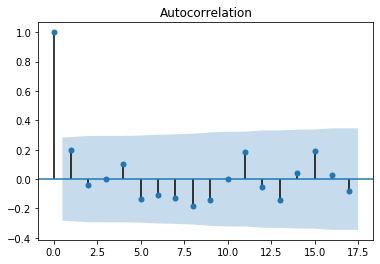

In [20]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)
print(test_results)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

### Checking For Normally Distributed Residuals
This one is easy to check for; we will do it visually. This will require using a QQ pplot which help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential. It’s just a visual check, not an air-tight proof, so it is somewhat subjective.

Visually what we are looking for is the data hugs the line tightly; this would give us confidence in our assumption that the residuals are normally distributed. Now, it is highly unlikely that the data will perfectly hug the line, so this is where we have to be subjective.

### Checking the Mean of the Residuals Equals 0
Additionally, we need to check another assumption, that the mean of the residuals is equal to zero. If the mean is very close to zero, then we are good to proceed. Just a side note, it's not uncommon to get a mean that isn't exactly zero; this is because of rounding errors. However, if it's very close to zero, it's ok. In the example below, you will see that it doesn't come out exactly to zero.

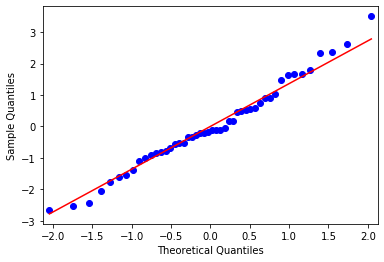

The mean of the residuals is -2.861e-14


In [21]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

### Measures of Error w.r.t - y_test & y_pred
We can examine how well our data fit the model, so we will take y_predictions and compare them to our y_actuals these will be our residuals. From here we can calculate a few metrics to help quantify how well our model fits the data. Here are a few popular metrics:

### -Mean Absolute Error (MAE):
Is the mean of the absolute value of the errors. This gives an idea of magnitude but no sense of direction (too high or too low).

### Mean Squared Error (MSE):
Is the mean of the squared errors. MSE is more popular than MAE because MSE "punishes" more significant errors.

### Root Mean Squared Error (RMSE):
Is the square root of the mean of the squared errors. RMSE is even more favored because it allows us to interpret the output in y-units.

Luckily for us, sklearn and statsmodel both contain functions that will calculate these metrics for us. The examples below were calculated using the sklearn library and the math library.

In [22]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 0.707
MAE 0.611
RMSE 0.841


### R-Squared

The R-Squared metric provides us a way to measure the goodness of fit or, in other words, how well our data fits the model. The higher the R-Squared metric, the better the data fit our model. However, one limitation is that R-Square increases as the number of features increase in our model, so if I keep adding variables even if they're poor choices R-Squared will still go up! A more popular metric is the adjusted R-Square which penalizes more complex models, or in other words models with more exploratory variables. In the example below, I calculate the regular R-Squared value, however, the statsmodel summary will calculate the Adjusted R-Squared below.

In [23]:
model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.86


### Confidence Intervals
Let's look at our confidence intervals. Keep in mind that by default confidence intervals are calculated using 95% intervals. We interpret confidence intervals by saying if the population from which this sample was drawn was sampled 100 times. Approximately 95 of those confidence intervals would contain the "true" coefficient.

Why do we provide a confidence range? Well, it comes from the fact that we only have a sample of the population, not the entire population itself. Because of this, it means that the "true" coefficient could exist in the interval below or it couldn't, but we cannot say for sure. We provide some uncertainty by providing a range, usually 95%, where the coefficient is probably in.

### Want a narrower range? Decrease your confidence.
### Want a wider range? Increase your confidence.

In [24]:
# make some confidence intervals, 95% by default
est.conf_int()

,0,1
const,-0.323322,4.210608
pop_growth,0.997064,3.366766
broad_money_growth,-0.037652,0.036865
gov_final_consum_growth,-0.372408,-0.005139
gross_cap_form_growth,0.079057,0.179616
hh_consum_growth,0.325648,0.667975
unemployment,-0.570237,0.558631


### Hypothesis Testing
With hypothesis testing, we are trying to determine the statistical significance of the coefficient estimates. This test is outlined as the following.

### Null Hypothesis: There is no relationship between the exploratory variables and the explanatory variable.
### Alternative Hypothesis: There is a relationship between the exploratory variables and the explanatory variable.

#### If we reject the null, we are saying there is a relationship, and the coefficients do not equal 0.
#### If we fail to reject the null, we are saying there is no relationship, and the coefficients do equal 0

In [25]:
# estimate the p-values
est.pvalues

const                      9.088069e-02
pop_growth                 5.996378e-04
broad_money_growth         9.830934e-01
gov_final_consum_growth    4.419934e-02
gross_cap_form_growth      5.978663e-06
hh_consum_growth           6.801951e-07
unemployment               9.835355e-01
dtype: float64

Here it's a little hard to tell, but we have a few insignificant coefficients. The first is the constant itself, so technically this should be dropped. However, we will see that once we remove the irrelevant variables that the intercept becomes significant. If it still wasn't significant, we could have our intercept start at 0 and assume that the cumulative effect of X on Y begins from the origin (0,0). Along with the constant, we have unemployment and broad_money_growth both come out as insignificant.

### Create a Summary of the Model Output
Let's create a summary of some of our keep metrics, sklearn does not have a good way of creating this output so we would have to calculate all the parameters ourselves. Let's avoid this and use the statsmodel.api library as we can create the same model we did up above, but we can also leverage the summary() method to create an output for us. Some of the metrics might differ slightly, but they generally should be the same.

In [26]:
# print out a summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     57.17
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.36e-18
Time:                        10:45:50   Log-Likelihood:                -82.903
No. Observations:                  48   AIC:                             179.8
Df Residuals:                      41   BIC:                             192.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The first thing we notice is that the p-values from up above are now easier to read and we can now determine that the coefficients that have a p-value greater than 0.05 can be removed. We also have our 95% confidence interval (described up above), our coefficient estimates (described up above), the standard errors, and t-values.

The other metric that stands out is our Adjusted R-Squared value which is .878, lower than our R-Squared value. This makes sense as we were probably docked for the complexity of our model. However, an R-Squared over .878 is still very strong.

The only additional metrics we will describe here is the t-value which is the coefficient divided by the standard error. The higher the t-value, the more evidence we have to reject the null hypothesis. Also the standard error, the standard error is the approximate standard deviation of a statistical sample population.

### Section Seven: Remove the Insignificant Variables.

Now that we know which variables are insignificant we should remove them from the model and refit the data to see what we get, the steps are the same the only thing I'm changing is that I am removing some additional columns from the data frame.

In [27]:
# define our input variable (X) & output variable
econ_df_after = econ_df.drop(['birth_rate', 'final_consum_growth','gross_capital_formation','broad_money_growth',
                              'unemployment'], axis = 1)

X = econ_df_after.drop('gdp_growth', axis = 1)
Y = econ_df_after[['gdp_growth']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     89.94
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.61e-20
Time:                        10:50:46   Log-Likelihood:                -82.904
No. Observations:                  48   AIC:                             175.8
Df Residuals:                      43   BIC:                             185.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Looking at the output, we now see that all of the independent variables are significant and even our constant 
is significant. We could rerun our test for autocorrelation and, but the tests will take you to the same conclusions we found above so I decided to leave that out of the tutorial. At this point, we can interpret our formula and begin making predictions. Looking at the coefficents, we would say pop_growth, gross_cap_form_growth, and hh_consum_growth all have a positive effect on GDP growth. Additionally, we would say that gov_final_consum_growth has a negative effect on GDP growth. That's a little surprising to see, but we would have to see why that might be the case.

### Section Eight: Save the Model for Future Use
We will probably want to use this model in the future, so let us save our work so we can use it later. Saving the model can be achieved by storing our model in a pickle which is storing a python object as a character stream in a file which can be reloaded later to use.

In [29]:
import pickle

# pickle the model
with open('my_mulitlinear_regression.sav','wb') as f:
     pickle.dump(regression_model, f)

# load it back in
with open('my_mulitlinear_regression.sav', 'rb') as pickle_file:
     regression_model_2 = pickle.load(pickle_file)

# make a new prediction
regression_model_2.predict([X_test.loc[2002]])

array([[7.6042968]])